In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import csv
import cv2
import os
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [2]:
import urllib
import cv2, csv
from matplotlib import pyplot as plt
%matplotlib inline
 
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    try:
        resp = urllib.request.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return image
    except:
        return None

In [3]:
data_info = {}
with open("IMDb-Face.csv", "r", encoding="utf8") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in tqdm(enumerate(reader)):
        if line[0] in data_info:
            data_info[line[0]] += 1
        else:
            data_info[line[0]] = 1

In [4]:
len(data_info)

59305

In [5]:
stats = data_info

In [6]:
max(stats, key=stats.get)

'Peter_Loung'

In [7]:
data_info['Peter_Loung']

10455

(array([1., 1., 0., ..., 0., 0., 1.]),
 array([    1,     2,     3, ..., 10453, 10454, 10455]),
 <a list of 10454 Patch objects>)

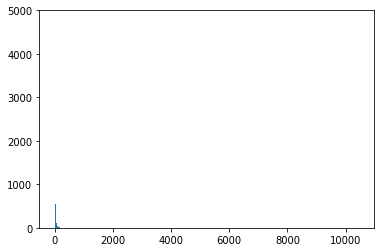

In [79]:
data = list(data_info.values())
plt.hist(data, bins=np.arange(min(data), max(data)+1))

In [8]:
freq = {}
for key in data_info:
    value = data_info[key]
    if value in freq:
        freq[value] += 1
    else:
        freq[value] = 1

In [9]:
celebs = [key for key in data_info if data_info[key]>150]
len(celebs)

1061

In [10]:
celebs = celebs[:10]
celebs

['Randolph_Scott',
 'Danny_Boyle',
 'Temperance_Lancecouncil',
 'Dennis_Quaid',
 'Victoria_Mullen',
 'James_Van_Der_Beek',
 'Tiffany_Michelle',
 'John_C._Reilly',
 'Jussie_Smollett',
 'Nathan_Fillion']

In [25]:
output_dir="./images/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

num_imgs = 4 #number of images per celeb
done = {}

count = 1

with open("IMDb-Face.csv", "r", encoding="utf8") as f:
    w_f = open(os.path.join(output_dir,"labels.csv"), mode='w+', newline="\n", encoding="utf-8")
    writer = csv.writer(w_f)
        
    reader = csv.reader(f, delimiter=",")
    for i, line in tqdm(enumerate(reader), total=num_imgs):
        if i==0:
            continue
        celeb_name = line[0]
        
        if celeb_name not in celebs:
            continue
            
        if celeb_name not in done:
            done[celeb_name] = 0
            
        if done[celeb_name]==num_imgs:
            continue

        img_filename = os.path.join(output_dir, "%d.jpg"%count)
#         faces_img_dir = os.path.join(output_dir, "Faces", celeb_name)
#         full_img_dir = os.path.join(output_dir,"Full", celeb_name)
#         if not os.path.exists(faces_img_dir):
#             os.makedirs(faces_img_dir)
#         if not os.path.exists(full_img_dir):
#             os.makedirs(full_img_dir)

        size = [int(x) for x in line[4].split()]
        bounds = [int(x) for x in line[3].split()]
        url = line[5]
        image = url_to_image(url)
        if image is not None:
            image = cv2.resize(image, (size[1], size[0]))
            image = image[:,:,::-1]
            try:
#                 plt.imsave(os.path.join(full_img_dir, line[2]), image)
                image = image[bounds[1]:bounds[3],bounds[0]:bounds[2],:]
                plt.imsave(img_filename, image)
                done[celeb_name] += 1
                
                writer.writerow([img_filename, celeb_name])
                count += 1
            except:
                pass
    w_f.close()

In [44]:
import torch, torchvision
import torch.utils.data
import pandas as pd
import io

In [45]:
train_dir = os.path.join("images")

In [60]:
from torch.utils.data.dataset import Dataset

class FacesDataset(Dataset):
    def __init__(self, root_dir, csv_file):
        self.labels_frame = pd.read_csv(os.path.join(root_dir, csv_file))
        self.root_dir = root_dir
        self.transform = None
        
    def __getitem__(self, idx):
        img_name = os.path.join(self.labels_frame.iloc[idx, 0])
        image = plt.imread(img_name)
        sample = (idx, (image, self.labels_frame.iloc[idx, 1]))

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.labels_frame)

In [61]:
face_dataset = FacesDataset(csv_file='labels.csv', root_dir='images')

In [62]:
i = 5
sample = face_dataset[i]

In [64]:
for i, (input, target) in enumerate(face_dataset):
    print(i)
    break

0


# Look here!

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dataset import get_celeb_list, fetch_images, FacesDataset
import os

num_train = 80
num_val = 10
num_test = 10
num_celebs = 500

celebs = get_celeb_list()
fetch_images(prefix, celebs, num_train, num_val, num_test, num_celebs)


 Cedric_the_Entertainer : ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [17]:
train_data = FacesDataset(os.path.join("images","train"), os.path.join("images","train_labels.csv"))
val_data = FacesDataset(os.path.join("images","val"), os.path.join("images","val_labels.csv"))
test_data = FacesDataset(os.path.join("images","test"), os.path.join("images","test_labels.csv"))

In [19]:
for i in train_data:
    print(i)
    break

(0, (array([[[112, 107, 103],
        [112, 107, 103],
        [110, 105, 101],
        ...,
        [ 95,  86,  81],
        [ 93,  84,  79],
        [ 87,  80,  74]],

       [[111, 106, 102],
        [108, 103,  99],
        [107, 102,  98],
        ...,
        [ 95,  86,  81],
        [ 91,  82,  77],
        [ 84,  77,  71]],

       [[111, 106, 102],
        [105, 100,  96],
        [102,  97,  93],
        ...,
        [ 95,  85,  83],
        [ 88,  81,  75],
        [ 79,  72,  66]],

       ...,

       [[ 62,  57,  53],
        [ 62,  57,  53],
        [ 60,  55,  51],
        ...,
        [137, 132, 128],
        [142, 137, 133],
        [151, 146, 142]],

       [[ 59,  54,  50],
        [ 62,  57,  53],
        [ 62,  57,  53],
        ...,
        [141, 136, 132],
        [147, 142, 138],
        [157, 152, 148]],

       [[ 58,  53,  49],
        [ 63,  58,  54],
        [ 66,  61,  57],
        ...,
        [139, 134, 130],
        [145, 140, 136],
        [155, 150, 